In [2]:
library(Biobase)
library(GEOquery)
library(data.table)
library(tidyverse)
library(RColorBrewer)
# creating heatmaps
library(gplots)
# for the jackstraw tests
library(jackstraw)
# calcuating q-values and FDRs
library(qvalue)
# combining ggplots
library(sva)
library(broom)
library(patchwork)
library(limma)
library(edge)
library(gridExtra)

Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which, which.max, which.min

Welcome to Bioconductor

    Vignettes contain introductory material; view with
    'browseVignettes()'. To cite B

## Epigenetic profiling in CD4+ and CD8+ T cells from Graves' disease patients reveals changes in genes associated with T cell receptor signaling.

> *Limbach et al.* Journal of Autoimmunity (2016) 

Graves' disease (GD) is an autoimmune disease affecting the thyroid. The disorder results from an antibody, called thyroid-stimulating immunoglobulin (TSI), that has a similar effect to thyroid stimulating hormone (TSH). These TSI antibodies cause the thyroid gland to produce excess thyroid hormones.

The ethymology of GD is complex; a combination of genetic, epigenetic and environmental factors contribute to the development of the disease. 
T cells play an important role in Graves' disease as they influence the production of thyroid-stimulating antibodies. Circulating T-cells, in particular CD4+ and CD8+ cells, infiltrate the thyroid and recognize epitopes on the thyroid stimulation hormone receptor (TSHR). The disruption of T cell signaling and activation could contribute to GD onset and progression. 

It has been suggested that enviromental factors could be influencing the performance of T cells through epigenetic modulations, in particular DNA hypermethylation.

In order to identify the epigenetic changes involved in GD, the authors performed DNA methylation analysis, gene expression measurements and ChIP-seq assays in sorted CD4+ and CD8+ T cells. 



### **Describe “your data” from the final project. What is the data about and how is the data obtained experimentally and computationally? At the minimum, follow the steps taken in this notebook to show various attributes, dimensions, and meta data.**

Although the study relies heavily on the integration of three experiments, the gene expression dataset for this analysis is suficient (and computationally undemanding). 

As GD is more prevalent in woman, the study was carried out among 69 female participant: 38 with past diagnosis of GD and 31 healthy individuals. The CD4+ and CD8+ cells were purified from blood and gene expression was measured with Illumina Expression BeadChips. 

In [3]:
#Loading a GDS file with GEOquery
dat <- getGEO('GSE71956', destdir=".", GSEMatrix= TRUE)

Found 1 file(s)
GSE71956_series_matrix.txt.gz
Parsed with column specification:
cols(
  .default = col_double(),
  ID_REF = col_character()
)
See spec(...) for full column specifications.
File stored at: 
./GPL10558.soft
Warning message:
“3270 parsing failures.
  row        col           expected    actual         file
29537 Unigene_ID 1/0/T/F/TRUE/FALSE Hs.571610 literal data
29538 Unigene_ID 1/0/T/F/TRUE/FALSE Hs.545780 literal data
29539 Unigene_ID 1/0/T/F/TRUE/FALSE Hs.554603 literal data
29540 Unigene_ID 1/0/T/F/TRUE/FALSE Hs.437179 literal data
29541 Unigene_ID 1/0/T/F/TRUE/FALSE Hs.128234 literal data
..... .......... .................. ......... ............
See problems(...) for more details.
”

In [4]:
key <- data.table(pData(dat[[1]]))
mat <- as.matrix(exprs(dat[[1]]))
anno <- data.table(fData(dat[[1]]))

In [5]:
class(mat)

[1] "matrix"

In [6]:
dim(key)
dim(mat)
dim(anno)

[1] 49 40

[1] 47323    49

[1] 47323    30

There are only 49 columns corresponding to 49 samples, which means that the low quality samples have been removed during the preprocessing.

In [7]:
mat[1:5,1:10]

,GSM1848135,GSM1848136,GSM1848137,GSM1848138,GSM1848139,GSM1848140,GSM1848141,GSM1848142,GSM1848143,GSM1848144
ILMN_1343291,13.758933,13.517861,13.450794,13.572097,13.875380,13.724038,13.675683,13.758933,13.802890,13.642941
ILMN_1343295,9.009108,9.344112,9.483680,9.302660,8.994604,8.600564,9.194007,9.067865,8.795162,9.121455
ILMN_1651199,4.424273,4.212721,4.200543,4.362133,4.218618,4.267591,4.277800,4.257838,4.237191,4.282191
ILMN_1651209,4.517634,4.740555,4.273515,4.199127,5.074448,4.302497,4.569198,4.727557,4.927775,4.778570
ILMN_1651210,4.381600,4.217415,4.637432,4.297888,4.294360,4.340287,4.342086,4.225946,4.431646,4.228312


In [8]:
colnames(key)

[1] "title"                   "geo_accession"          
 [3] "status"                  "submission_date"        
 [5] "last_update_date"        "type"                   
 [7] "channel_count"           "source_name_ch1"        
 [9] "organism_ch1"            "characteristics_ch1"    
[11] "characteristics_ch1.1"   "characteristics_ch1.2"  
[13] "characteristics_ch1.3"   "characteristics_ch1.4"  
[15] "molecule_ch1"            "extract_protocol_ch1"   
[17] "label_ch1"               "label_protocol_ch1"     
[19] "taxid_ch1"               "hyb_protocol"           
[21] "scan_protocol"           "data_processing"        
[23] "platform_id"             "contact_name"           
[25] "contact_email"           "contact_phone"          
[27] "contact_laboratory"      "contact_department"     
[29] "contact_institute"       "contact_address"        
[31] "contact_city"            "contact_zip/postal_code"
[33] "contact_country"         "supplementary_file"     
[35] "data_row_count"          "age:ch1"                
[37] "cell type:ch1"           "diagonsis:ch1"          
[39] "gender:ch1"              "tissue:ch1"

### Cleaning up key data

Columns: *status, submission_date, last_update_date, type, channel_count, organism_ch1, characteristics_ch1, characteristics_ch1.2, molecule_ch1, extract_protocol_ch1, label_ch1, label_protocol_ch1, taxid_ch1, hyb_protocol, scan_protocol, data_processing, platform_id, contact_name, contact_email, contact_phone, contact_laboratory, contact_department, contact_institute, contact_address, contact_city, contact_zip/postal_code, contact_country, data_row_count, gender:ch1, tissue:ch1* contain a single value for all the samples, therefore they can be ommited.

The *supplementary_file* column contains information irrelevant to this analysis (although the files contain important information on hormones concetrations, which could be relevant to the analysis. 

*characteristics_ch1.3* and *age:ch1* contain exactly the same information, so the former one was dropped. The same applies to *characteristics_ch1.4* and *diagnosis:ch1*, *characteristics_ch1.1* and *cell type:ch1*. The column *source_name_ch1* repeats the information from other columns and can also be labeled also dispensable. 

Changing the names of the columns for convinience reasons. 

**There are remarkably few informations on technical variables such as expression bead array chip or array row.**

In [9]:
# head(key, 5)
# key %>% distinct(`tissue:ch1`)
key <- key %>% mutate("sample" = rownames(key)) %>% select("sample" = sample, "title" = title, "age" = `age:ch1`,
                 "cell_type" = `cell type:ch1`, "diagnosis" = `diagonsis:ch1`, "geo" = geo_accession)
head(key)

sample,title,age,cell_type,diagnosis,geo
1,RNA_CD4_Control_rep1,50,CD4 T cells,Healthy,GSM1848135
2,RNA_CD4_Control_rep2,51,CD4 T cells,Healthy,GSM1848136
3,RNA_CD4_Control_rep3,50,CD4 T cells,Healthy,GSM1848137
4,RNA_CD4_Control_rep4,54,CD4 T cells,Healthy,GSM1848138
5,RNA_CD4_Control_rep5,52,CD4 T cells,Healthy,GSM1848139
6,RNA_CD4_Control_rep6,59,CD4 T cells,Healthy,GSM1848140


Removing rows with missing values is unnecessary. 

In [10]:
# remove the rows with missing values
length(mat)
rows.na <- apply(mat ,1,function(x) sum(is.na(x)))
length(mat[rows.na != 0,])

[1] 2318827

[1] 0

# Divide the datasets

In [11]:
cd4_geo <- filter(key, cell_type == "CD4 T cells")$geo
cd8_geo <- filter(key, cell_type == 'CD8 T cells')$geo

cd4_key <- filter(key, cell_type == "CD4 T cells")
cd8_key <- filter(key, cell_type == 'CD8 T cells')

In [13]:
cd4_mat <- as.data.frame(mat) %>% select(cd4_geo)
cd8_mat <- as.data.frame(mat) %>% select(cd8_geo)

In [14]:
ncol(cd4_mat)
nrow(cd4_key)

ncol(cd8_mat)
nrow(cd8_key)

[1] 25

[1] 25

[1] 24

[1] 24

# CD8

## Data visualization

The plots shown below suggest that some kind of transormation was applied to the data, as shown on the boxplot and violin plot (all the samples are similar). However, the data are not scaled. 

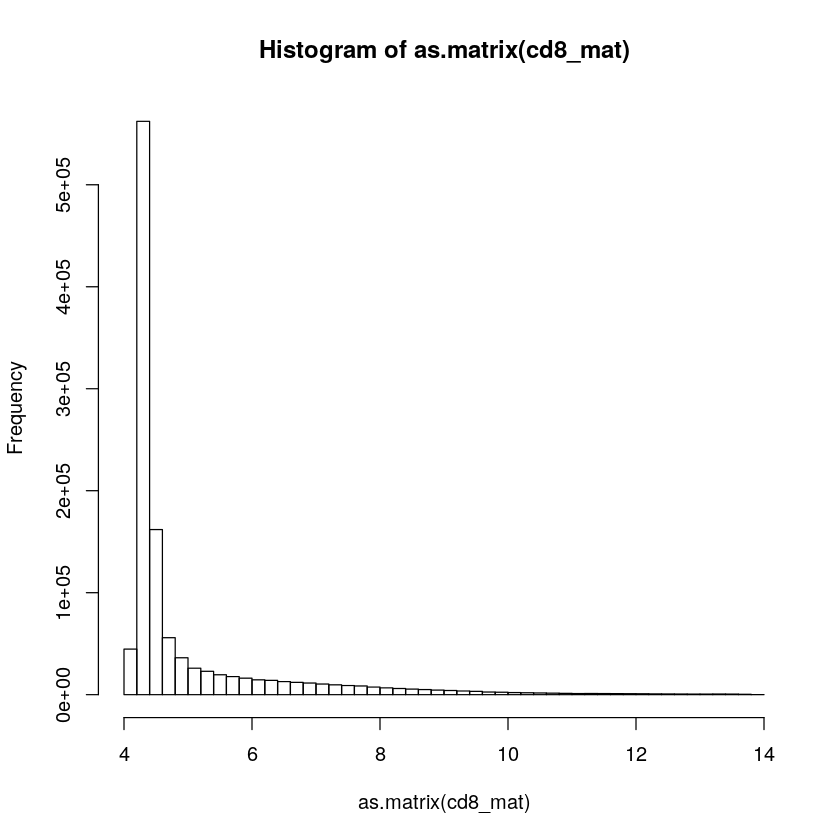

In [22]:
hist(as.matrix(cd8_mat), breaks=50)

In [23]:
cd8_mat_gathered <- as.data.frame(cd8_mat) %>%
                    gather("sample", "value")


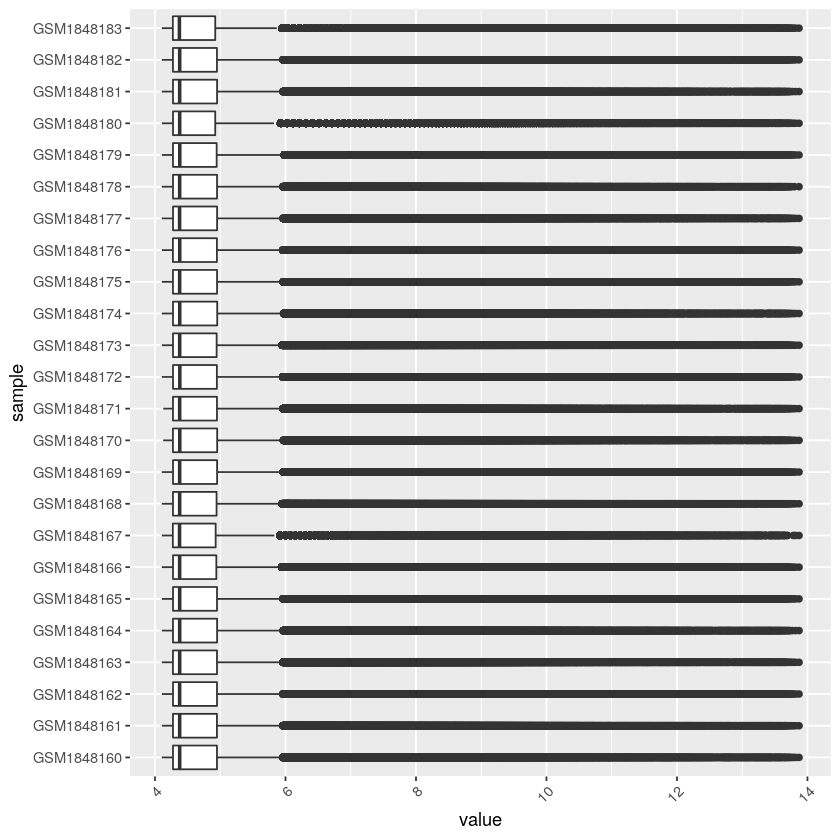

In [24]:
ggplot(cd8_mat_gathered, aes(x=sample, y=value)) +
    geom_boxplot() + 
    theme(axis.text.x = element_text(angle=45, hjust=1)) +
    coord_flip()


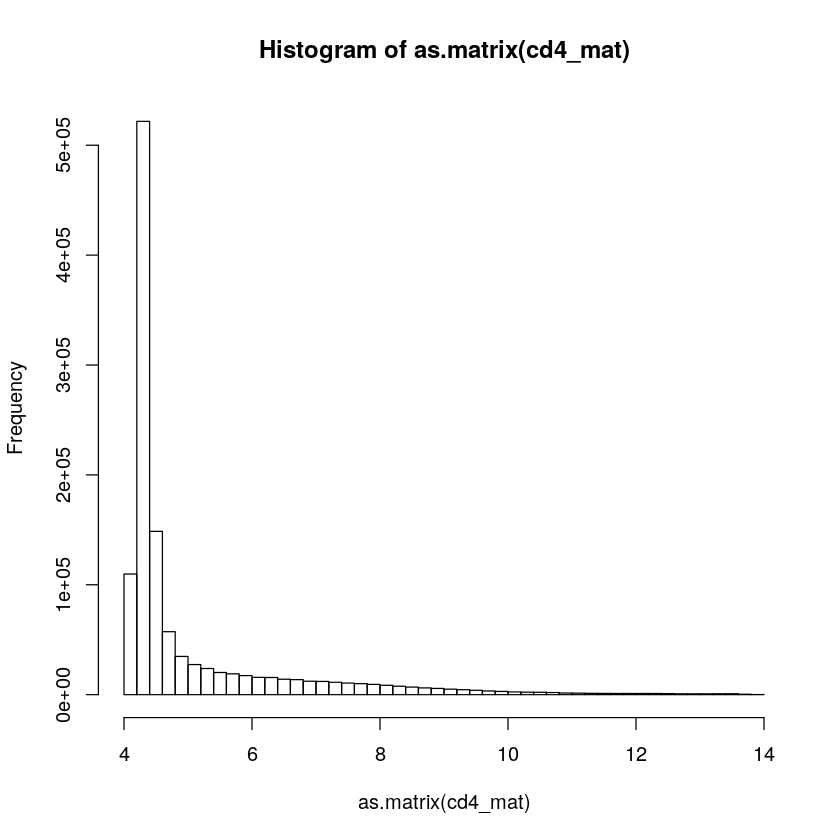

In [27]:
hist(as.matrix(cd4_mat), breaks=50)

In [25]:
cd4_mat_gathered <- as.data.frame(cd4_mat) %>%
                    gather("sample", "value")


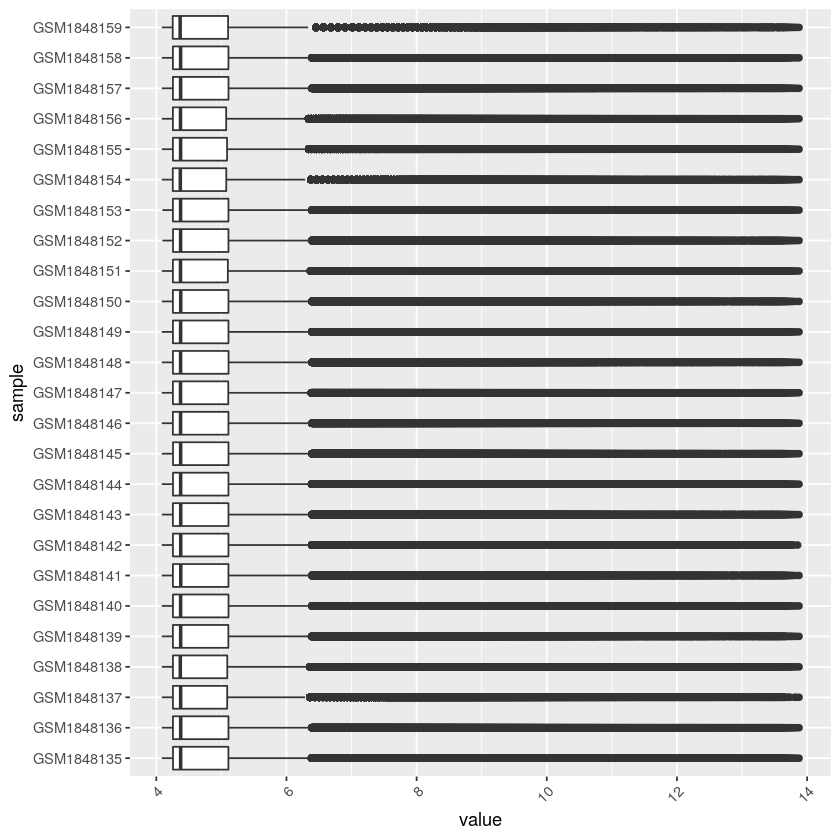

In [26]:
ggplot(cd4_mat_gathered, aes(x=sample, y=value)) +
    geom_boxplot() + 
    theme(axis.text.x = element_text(angle=45, hjust=1)) +
    coord_flip()


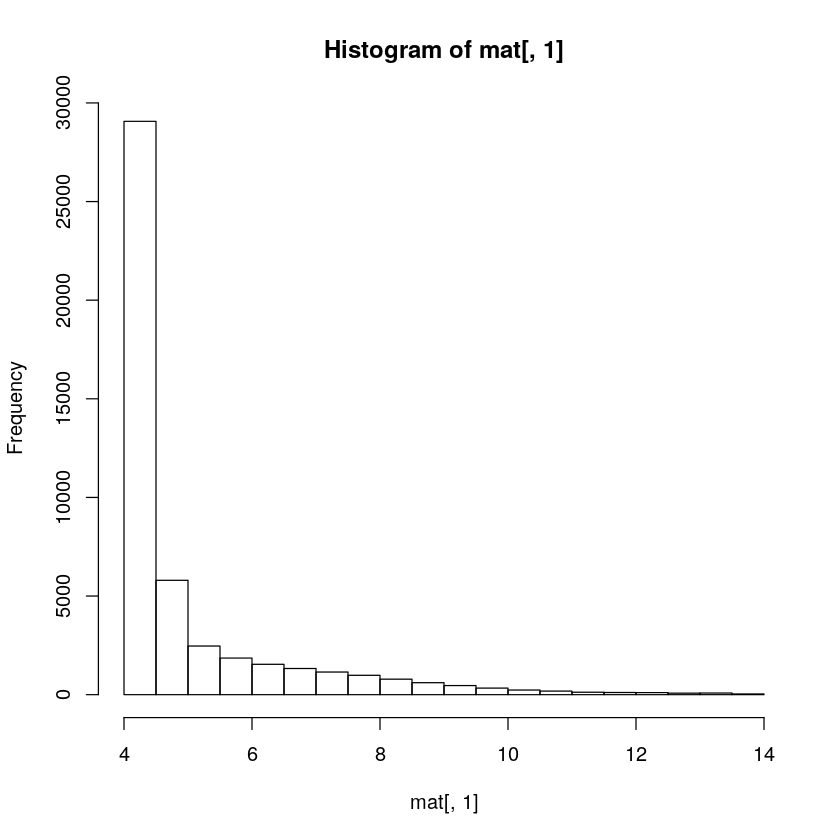

In [18]:
hist(mat[,1])

### Linear regression model

# CD8

In [41]:
combat_cd8_mat <- ComBat(dat = as.matrix(cd8_mat), batch = as.numeric(cd8_key$age), 
                     mod = model.matrix(~as.factor(diagnosis),
                                        data = cd8_key),
                     par.prior=TRUE, prior.plots=FALSE)

Found16batches
Note: one batch has only one sample, setting mean.only=TRUE
Adjusting for1covariate(s) or covariate level(s)


Standardizing Data across genes


Fitting L/S model and finding priors
Finding parametric adjustments
Adjusting the Data



In [42]:
head(cd8_mat, 5)
head(combat_cd8_mat,5)

,GSM1848160,GSM1848161,GSM1848162,GSM1848163,GSM1848164,GSM1848165,GSM1848166,GSM1848167,GSM1848168,GSM1848169,...,GSM1848174,GSM1848175,GSM1848176,GSM1848177,GSM1848178,GSM1848179,GSM1848180,GSM1848181,GSM1848182,GSM1848183
ILMN_1343291,13.696663,13.755981,13.120064,13.613389,13.870531,13.570831,13.129013,13.274862,13.594263,13.783946,...,13.071945,13.870531,13.333398,13.060132,13.313030,12.759938,5.077882,13.720981,13.783946,12.774788
ILMN_1343295,8.677459,8.759160,8.264699,8.202794,8.948746,9.005146,9.272301,9.786646,8.168201,8.945019,...,7.954786,8.328205,9.298727,7.781577,8.919145,8.912437,10.723406,8.743616,8.699301,9.329550
ILMN_1651199,4.253281,4.233789,4.245613,4.318693,4.234371,4.234981,4.262469,4.392777,4.441813,4.225703,...,4.369757,4.303861,4.267877,4.206044,4.277514,4.258387,4.354968,4.224630,4.347341,4.260029
ILMN_1651209,4.541584,4.863705,5.241303,4.479208,4.727037,4.504696,5.062978,4.185778,4.494784,4.607517,...,4.296045,4.314507,5.029676,4.614125,4.584766,4.275429,5.723838,4.603473,4.633402,4.301976
ILMN_1651210,4.275867,4.199585,4.334578,4.174902,4.362438,4.297108,4.236248,4.190670,4.231590,4.242848,...,4.215872,4.367379,4.190922,4.198824,4.285172,4.449203,4.288698,4.282319,4.255618,5.454296


,GSM1848160,GSM1848161,GSM1848162,GSM1848163,GSM1848164,GSM1848165,GSM1848166,GSM1848167,GSM1848168,GSM1848169,...,GSM1848174,GSM1848175,GSM1848176,GSM1848177,GSM1848178,GSM1848179,GSM1848180,GSM1848181,GSM1848182,GSM1848183
ILMN_1343291,13.137669,13.275972,12.763464,13.422185,13.513932,13.108454,12.943037,13.088886,13.177052,13.303938,...,12.880741,13.513932,13.147423,13.096696,13.160496,13.083707,13.065735,13.227186,13.597971,12.695883
ILMN_1343295,8.893864,8.740010,8.495162,8.701126,9.179210,8.963339,9.016073,9.530417,8.581153,8.925869,...,8.453118,8.558668,9.042499,8.510892,8.728964,8.654614,8.657047,8.678535,8.443072,9.231044
ILMN_1651199,4.272493,4.272606,4.260904,4.280239,4.249663,4.268564,4.244859,4.375167,4.315522,4.264520,...,4.331303,4.319152,4.250267,4.278139,4.290085,4.290610,4.291979,4.279709,4.329730,4.286158
ILMN_1651209,4.771165,4.879078,5.265154,4.726462,4.750889,4.763166,5.083282,4.206083,4.622689,4.622890,...,4.543300,4.338359,5.049980,4.643437,4.641646,4.627349,4.643263,4.642466,4.653706,4.251757
ILMN_1651210,4.310740,4.280063,4.328756,4.270972,4.356616,4.314723,4.309731,4.264153,4.316802,4.323327,...,4.311941,4.361556,4.264405,4.311840,4.328896,4.329032,4.327113,4.326181,4.329101,5.035017


In [43]:
combat_cd4_mat <- ComBat(dat = as.matrix(cd4_mat), batch = cd4_key$age, 
                     mod = model.matrix(~as.factor(diagnosis),
                                      data=cd4_key),
                     par.prior=TRUE, prior.plots=FALSE)

Found15batches
Note: one batch has only one sample, setting mean.only=TRUE
Adjusting for1covariate(s) or covariate level(s)


Standardizing Data across genes


Fitting L/S model and finding priors
Finding parametric adjustments
Adjusting the Data



In [44]:
head(cd4_mat, 5)
head(combat_cd4_mat,5)

,GSM1848135,GSM1848136,GSM1848137,GSM1848138,GSM1848139,GSM1848140,GSM1848141,GSM1848142,GSM1848143,GSM1848144,...,GSM1848150,GSM1848151,GSM1848152,GSM1848153,GSM1848154,GSM1848155,GSM1848156,GSM1848157,GSM1848158,GSM1848159
ILMN_1343291,13.758933,13.517861,13.450794,13.572097,13.875380,13.724038,13.675683,13.758933,13.802890,13.642941,...,13.696184,13.292182,13.463747,13.487833,12.919791,12.834537,13.059583,13.455448,13.668093,12.976035
ILMN_1343295,9.009108,9.344112,9.483680,9.302660,8.994604,8.600564,9.194007,9.067865,8.795162,9.121455,...,9.745164,8.207432,10.149067,9.427738,9.620411,9.297919,8.610468,9.392684,8.938453,10.418637
ILMN_1651199,4.424273,4.212721,4.200543,4.362133,4.218618,4.267591,4.277800,4.257838,4.237191,4.282191,...,4.431483,4.353459,4.406038,4.338511,7.302074,4.510021,4.676357,4.307246,4.267002,4.151508
ILMN_1651209,4.517634,4.740555,4.273515,4.199127,5.074448,4.302497,4.569198,4.727557,4.927775,4.778570,...,4.651852,5.628588,4.730589,4.424273,6.289443,4.220659,6.496300,4.482040,4.520894,4.329056
ILMN_1651210,4.381600,4.217415,4.637432,4.297888,4.294360,4.340287,4.342086,4.225946,4.431646,4.228312,...,4.314087,4.366571,4.463380,4.338511,4.995637,4.298217,4.241620,4.289178,4.298217,4.276751


,GSM1848135,GSM1848136,GSM1848137,GSM1848138,GSM1848139,GSM1848140,GSM1848141,GSM1848142,GSM1848143,GSM1848144,...,GSM1848150,GSM1848151,GSM1848152,GSM1848153,GSM1848154,GSM1848155,GSM1848156,GSM1848157,GSM1848158,GSM1848159
ILMN_1343291,13.748885,13.520076,13.440746,13.574845,13.789775,13.637903,13.590078,13.730348,13.805638,13.625982,...,13.698933,13.430591,13.476904,13.459248,12.922539,13.444677,13.451121,13.470796,13.670842,13.044219
ILMN_1343295,8.881989,9.293313,9.356561,9.262875,9.069511,8.937231,9.268915,9.031994,8.755377,9.108866,...,9.705379,8.944351,9.523627,9.391866,9.580626,9.175422,9.149186,9.247457,8.898668,10.109596
ILMN_1651199,4.306331,4.302327,4.082601,4.210346,4.282403,4.200015,4.341584,4.334490,4.085404,4.237300,...,4.279696,4.559326,4.565249,4.415163,7.150287,4.599344,4.606608,4.535723,4.115215,4.464018
ILMN_1651209,4.770513,4.847077,4.526394,4.179604,5.138419,4.641539,4.633168,4.866138,4.908252,4.796444,...,4.632329,5.053779,4.830089,4.562854,6.269919,4.825615,4.914379,4.755427,4.501370,4.247906
ILMN_1651210,4.237702,4.278044,4.493535,4.263808,4.316408,4.317588,4.364134,4.265381,4.397565,4.278561,...,4.280007,4.387832,4.421687,4.377946,4.961556,4.385739,4.383314,4.364505,4.264136,4.325191


# To test for differential expression between healthy controls and GD patients, age and the expression bead array chip were included in a linear regression model as covariates to test for differential expression with the “limma” software. Genes with the FDR adjusted p-value < 0.1 and a fold change >1.5 were considered to be differentially expressed.

In [49]:
model <- model.matrix(~ cd8_key$diagnosis)
cd8_fit <- lmFit(cd8_mat, model)
cd8_fit <- eBayes(cd8_fit)
cd8_fit <- topTable(cd8_fit, coef=2, number=nrow(cd8_mat))


[1] 13778

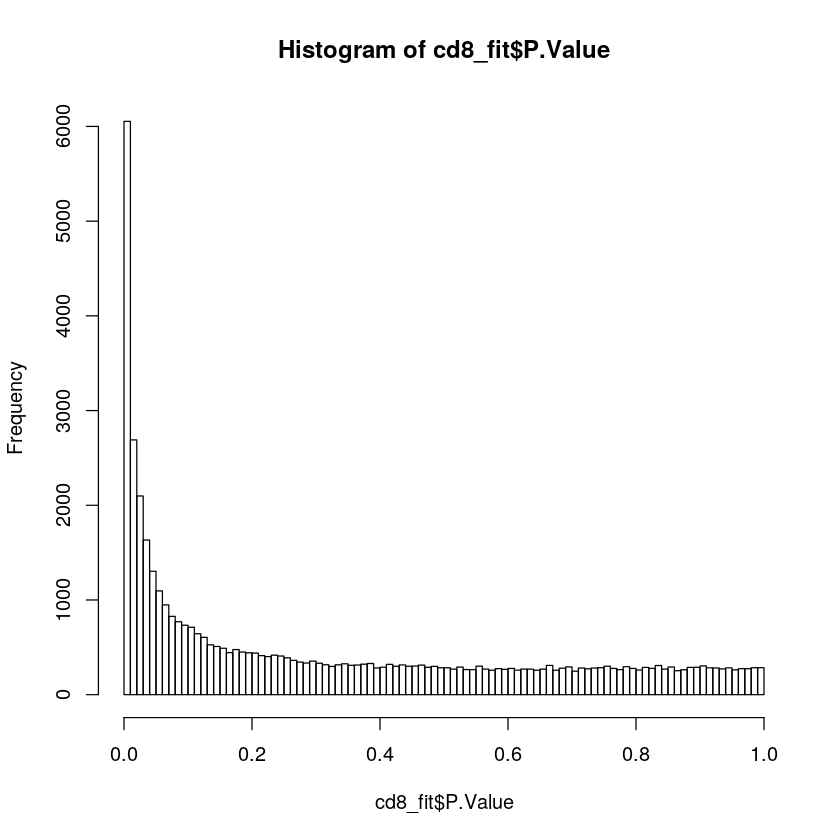

In [50]:
sum(cd8_fit$P.Value < 0.05)
hist(cd8_fit$P.Value, breaks=100)

In [53]:
cd8_probes <- cd8_fit %>% mutate("probe" = rownames(cd8_fit)) %>% filter(P.Value < 0.1 & logFC > 0.176)

In [54]:
length(cd8_probes)

[1] 7

In [55]:
cd8_expr <- (as.data.frame(cd8_mat) %>%
            mutate("probe" = rownames(cd8_mat)) %>%
            filter(row.names(cd8_mat) %in% cd8_probes$probe))

In [56]:
rownames(cd8_expr) = cd8_expr$probe
cd8_expr = cd8_expr[, -ncol(cd8_expr)]

In [64]:
head(cd8_expr)
head(cd4_expr)

,GSM1848160,GSM1848161,GSM1848162,GSM1848163,GSM1848164,GSM1848165,GSM1848166,GSM1848167,GSM1848168,GSM1848169,...,GSM1848174,GSM1848175,GSM1848176,GSM1848177,GSM1848178,GSM1848179,GSM1848180,GSM1848181,GSM1848182,GSM1848183
ILMN_1343295,8.893864,8.740010,8.495162,8.701126,9.179210,8.963339,9.016073,9.530417,8.581153,8.925869,...,8.453118,8.558668,9.042499,8.510892,8.728964,8.654614,8.657047,8.678535,8.443072,9.231044
ILMN_1651221,4.672906,4.626980,4.879975,4.455175,4.467565,4.692436,4.182007,5.961452,4.468129,4.453871,...,4.667951,4.483803,4.302984,4.411460,4.442554,4.418098,4.410675,4.423734,4.359383,4.825795
ILMN_1651288,4.721023,4.600742,4.639612,4.550603,4.782559,4.739509,4.798938,5.358050,4.642529,4.676786,...,4.740922,4.492882,4.421580,4.610912,4.544914,4.647923,4.582509,4.558574,4.505347,4.503708
ILMN_1651316,8.994515,8.789962,8.390037,9.456783,9.065778,8.993267,8.880417,8.588025,8.090349,8.474919,...,7.809792,8.653924,7.238884,7.945691,8.274976,7.831719,7.841499,7.934281,7.394533,5.686368
ILMN_1651325,4.510701,4.399091,4.387873,4.343355,4.504486,4.517959,4.165462,5.709779,4.221174,4.299656,...,4.375661,4.359117,4.105166,4.233817,4.248353,4.205798,4.207440,4.223119,4.065029,4.199186
ILMN_1651341,4.915445,5.096765,5.255442,4.521946,4.735730,4.971549,4.856181,5.916102,4.632175,4.579893,...,5.144525,4.811361,4.542740,4.685719,4.629146,4.704570,4.688223,4.676206,4.536544,5.197443


,GSM1848135,GSM1848136,GSM1848137,GSM1848138,GSM1848139,GSM1848140,GSM1848141,GSM1848142,GSM1848143,GSM1848144,...,GSM1848150,GSM1848151,GSM1848152,GSM1848153,GSM1848154,GSM1848155,GSM1848156,GSM1848157,GSM1848158,GSM1848159
ILMN_1651262,8.512601,8.422841,7.859521,8.538718,8.272984,8.291457,8.145686,8.326853,8.315186,8.197223,...,8.223178,7.847938,7.913849,7.977151,5.872972,7.737457,7.755973,8.180215,8.849200,6.872709
ILMN_1651316,9.063993,9.502831,9.802062,9.718642,9.564967,9.603562,9.774634,9.781636,9.481677,9.535073,...,9.352553,8.574487,9.077600,9.269264,8.335458,8.513692,8.611861,8.575142,7.989811,5.798147
ILMN_1651328,5.916440,5.461242,5.742456,6.873535,5.845967,5.554113,5.177152,5.803357,5.817317,5.811238,...,4.972976,5.329395,5.166646,5.123116,4.329477,5.278614,5.294974,5.103882,5.046630,4.289322
ILMN_1651496,6.435547,5.310555,4.931734,5.347069,6.764982,5.760597,6.310121,5.680849,7.093341,5.767725,...,5.859065,5.505335,5.024925,6.471547,4.244876,5.017865,5.011938,4.913235,4.337077,3.983231
ILMN_1651507,6.002440,5.608859,4.639851,5.131353,6.028278,5.550834,5.659014,5.716622,5.270668,5.330452,...,5.591423,5.275450,5.363994,5.603789,4.433932,5.127664,5.121365,5.001355,4.936548,4.605160
ILMN_1651532,4.466792,4.422244,4.672516,6.084544,4.386250,4.571189,4.419456,4.390376,4.337338,4.567178,...,4.174765,4.274565,4.262562,4.465345,4.198304,4.271558,4.267191,4.273121,4.215337,5.192826


In [58]:
model <- model.matrix(~ cd4_key$diagnosis)
cd4_fit <- lmFit(cd4_mat, model)
cd4_fit <- eBayes(cd4_fit)
cd4_fit <- topTable(cd4_fit, coef=2, number=nrow(cd4_mat))


[1] 6348

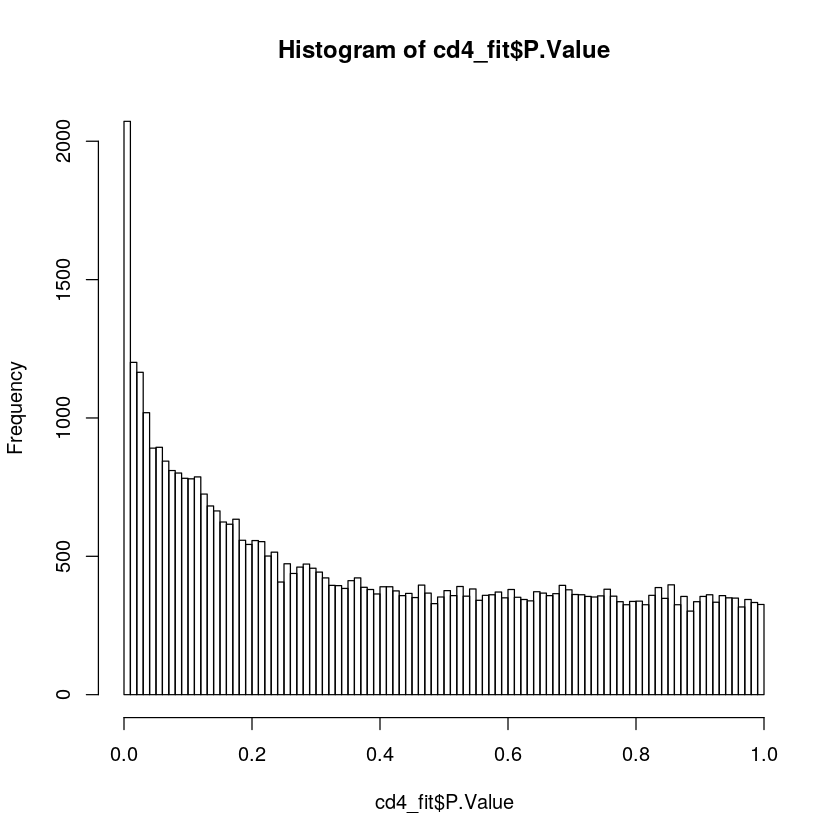

In [59]:
sum(cd4_fit$P.Value < 0.05)
hist(cd4_fit$P.Value, breaks=100)

In [60]:
cd4_probes <- cd4_fit %>% mutate("probe" = rownames(cd4_fit)) %>% filter(P.Value < 0.1 & logFC > 0.176)

In [73]:
head(cd4_probes)

logFC,AveExpr,t,P.Value,adj.P.Val,B,probe
0.2257468,4.373648,7.198581,1.856694e-07,0.003067402,6.868975,ILMN_1733156
1.2390997,6.163850,7.055810,2.592737e-07,0.003067402,6.584995,ILMN_1752510
0.4243397,4.629126,6.813885,4.592402e-07,0.004346525,6.096284,ILMN_1712211
0.2397462,4.389167,6.726008,5.662456e-07,0.004347677,5.916464,ILMN_1749646
0.3529804,4.586976,6.348408,1.407364e-06,0.006703536,5.130346,ILMN_1858762
0.3848488,4.693545,6.233817,1.861220e-06,0.007523474,4.887617,ILMN_1725963


In [62]:
cd4_expr <- (as.data.frame(cd4_mat) %>%
            mutate("probe" = rownames(cd4_mat)) %>%
            filter(row.names(cd4_mat) %in% cd4_probes$probe))

In [63]:
rownames(cd4_expr) = cd4_expr$probe
cd4_expr = cd4_expr[, -ncol(cd4_expr)]

In [69]:
cd4_expr_key <- cd4_key
cd8_expr_key <- cd8_key

cd4_expr_anno <- anno %>% filter(ID %in% cd4_probes$probe)
cd8_expr_anno <- anno %>% filter(ID %in% cd8_probes$probe)


In [70]:
head(cd4_expr_anno)

ID,Species,Source,Search_Key,Transcript,ILMN_Gene,Source_Reference_ID,RefSeq_ID,Unigene_ID,Entrez_Gene_ID,...,Probe_Chr_Orientation,Probe_Coordinates,Cytoband,Definition,Ontology_Component,Ontology_Process,Ontology_Function,Synonyms,Obsolete_Probe_Id,GB_ACC
ILMN_1651262,Homo sapiens,RefSeq,NM_031266.2,ILMN_1758,HNRNPAB,NM_004499.3,NM_004499.3,NA,3182,...,+,177570393-177570442,5q35.3b,"Homo sapiens heterogeneous nuclear ribonucleoprotein A/B (HNRNPAB), transcript variant 2, mRNA.","A membrane-bounded organelle of eukaryotic cells in which chromosomes are housed and replicated. In most cells, the nucleus contains all of the cell's chromosomes except the organellar chromosomes, and is the site of RNA synthesis and processing. In some species, or in specialized cell types, RNA metabolism or DNA replication may be absent [goid 5634] [evidence ISS]; All of the contents of a cell excluding the plasma membrane and nucleus, but including other subcellular structures [goid 5737] [evidence ISS]","A transition where an epithelial cell loses apical/basolateral polarity, severs intercellular adhesive junctions, degrades basement membrane components and becomes a migratory mesenchymal cell [goid 1837] [evidence ISS]; Any process that activates or increases the frequency, rate or extent of the DNA-dependent transcription of a specific gene or genes [goid 43193] [evidence ISS]","Interacting selectively with a nucleotide, any compound consisting of a nucleoside that is esterified with (ortho)phosphate or an oligophosphate at any hydroxyl group on the ribose or deoxyribose moiety [goid 166] [evidence IEA]; The function of binding to a specific DNA sequence in order to modulate transcription. The transcription factor may or may not also interact selectively with a protein or macromolecular complex [goid 3700] [evidence ISS]; Interacting selectively with pre-messenger RNA (pre-mRNA) or messenger RNA (mRNA) [goid 3729] [pmid 8999813] [evidence TAS]; Interacting selectively with any protein or protein complex (a complex of two or more proteins that may include other nonprotein molecules) [goid 5515] [pmid 17353931] [evidence IPI]; Interacting selectively with DNA of a specific nucleotide composition, e.g. GC-rich DNA binding, or with a specific sequence motif or type of DNA e.g. promotor binding or rDNA binding [goid 43565] [evidence ISS]",ABBP1; FLJ40338,FLJ40338; ABBP1,NM_004499.3
ILMN_1651316,Homo sapiens,RefSeq,NM_001781.1,ILMN_13491,CD69,NM_001781.1,NM_001781.1,NA,969,...,-,9796974-9797023,12p13.31a,"Homo sapiens CD69 molecule (CD69), mRNA.","The side of the plasma membrane that is opposite to the side that faces the cytoplasm [goid 9897] [evidence IEA]; Penetrating at least one phospholipid bilayer of a plasma membrane. May also refer to the state of being buried in the bilayer with no exposure outside the bilayer [goid 5887] [pmid 8340758] [evidence TAS]; The side of the plasma membrane that is opposite to the side that faces the cytoplasm [goid 9897] [evidence IEA]; Double layer of lipid molecules that encloses all cells, and, in eukaryotes, many organelles; may be a single or double lipid bilayer; also includes associated proteins [goid 16020] [evidence IEA]",,"Combining with an extracellular or intracellular messenger to initiate a change in cell activity, and spanning to the membrane of either the cell or an organelle [goid 4888] [pmid 8340758] [evidence TAS]; The selective, often stoichiometric, interaction of a molecule with one or more specific sites on another molecule [goid 5488] [evidence IEA]; Interacting selectively with any mono-, di- or trisaccharide carbohydrate [goid 5529] [evidence IEA]",CLEC2C,CLEC2C,NM_001781.1
ILMN_1651328,Homo sapiens,RefSeq,XR_001385.1,ILMN_138298,LAT1-3TM,XR_001385.1,XR_001385.1,NA,81893,...,,,16p11.2d,"PREDICTED: Homo sapiens SLC7A5 pseudogene, transcript variant 2 (LAT1-3TM), misc RNA.",,,,,,XR_001385.1
ILMN_1651496,Homo sapiens,RefSeq,NM_138720.1,ILMN_17622,HIST1H2BD,NM_138720.1,NM_138720.1,NA,3017,.

In [75]:
save(cd4_expr, cd8_expr,
     cd4_expr_key, cd8_expr_key,
     cd4_expr_anno, cd8_expr_anno,
     cd4_probes, cd8_probes,
     file="/home/paulina/Pulpit/CBS/final_project/expr.RData")